In [1]:
from __future__ import division

In [2]:
import math
import random
import numpy as np
import pandas as pd

In [3]:
from sklearn import datasets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 1

%aimport gtree

In [133]:
import logging
%config Application.log_level="INFO"
logging.basicConfig(format='%(asctime)s %(name)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

## Goals:

### Separate the structure of a tree from the data of a tree.  In other words,
  fitting a tree does two things: It creates the structure of a tree and it
  creates a mapping of each leaf to a value.  Lookup therefore requires both
  finding the leaf node AND using the map to lookup the value.
  
### The loss function optimized by the tree is configurable, as is the leaf


## Terms:

### Tree
A Tree is an object that takes input data and determines what leaf it ends up in.  Unlike many tree implementations, the Tree itself doesn't store data about the value of a leaf.  That is stored externally.


### loss_fn
A loss_fn is a function that takes data rows, the predicted targets for those rows, and the actual targets for those rows, and returns a single value that determines the "LOSS" or "COST" of that prediction (lower cost/loss is better)

```
def loss_fn(predicted_targets, actual_targets) -> float
```

A loss function must be additive (so, one should not apply a mean as a part of it)

### leaf_prediction_fn
A leaf_prediction_fn is a function which takes the features and actual targets that end up in a leaf and returns a Series of the predictions for each row ending up in that leaf.  It is typically a constant function whose value is either the mean good rate in that leaf (among the actual targets) or the median target, but can be anything else

```
def leaf_prediction_fn(features) -> pd.Series
```


### leaf_prediction_builder
A leaf_prediction_builder is a function which takes the features and actual targets that end up in a TRANING leaf and returns a leaf_prediction_fn.  This leaf_prediction_fn is used to predict the value of testing rows that end up in the same leaf.

```
def leaf_prediction_builder(features, actual_targets) -> leaf_prediction_fn
```


### leaf_prediction_map
A leaf_prediction_map is a map of leaf ids (eg their hash) to the leaf_prediction_fn for that leaf.  One can only use a tree to score data if one has a leaf_prediction_map.  This design allows on to use the same tree as a subset of another tree without having their leaf values become entangled.

In [39]:
data = pd.DataFrame({'A': [0.1, 10, .02],
                     'B': [10, 20, 30]},
                    index=['foo', 'bar', 'baz'])

In [40]:
t = gtree.BranchNode('A', 0.5, None, None)
t.left = gtree.LeafNode() #'A', 0.5, 10, 20)
t.right = gtree.LeafNode() #'A', 0.5, 100, 0)

leaf_map = {hash(t.left): lambda x: 10,
            hash(t.right): lambda x: 20}

t.predict(data, leaf_map)

foo    10
bar    20
baz    10
dtype: int64

In [41]:
# Create a split on a DataFrame

df = pd.DataFrame({'foo': pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])})

gtree._single_variable_best_split(
    df,
    'foo',
    pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1]),
    gtree.accuracy_loss,
    gtree.leaf_good_rate_split_builder)

(2, 0.375)

In [42]:
threshold = 0.5
truth     = pd.Series([1, 0, 1])
predicted = pd.Series([0, 1, 0])

gtree.accuracy_loss(truth, predicted)


1.0 - ((predicted >= threshold) == truth).mean() #+ (predicted < threshold) * (1 - truth)

1.0

In [52]:
df = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'B': [10, 20, 50, 30, 40, 50, 60, 50, 70, 90, 100, 110 ]})
target = pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

tree, leaf_map = gtree.train_greedy_tree(df, target, loss_fn=gtree.accuracy_loss)

print '\nTree:\n'
tree.prn()

print leaf_map

Training.  Depth 0 Current Loss: 5 Best Split: B 40 3
Training.  Depth 1 Current Loss: 0 Best Split: A 1 0
Training.  Depth 1 Current Loss: 3 Best Split: A 10 1
Training.  Depth 2 Current Loss: 1 Best Split: A 1 1.0
Training.  Depth 2 Current Loss: 0 Best Split: A 1 0.0

Tree:

	Leaf(283736965)

B 40

		Leaf(283736809)

	A 10

		Leaf(283736109)

{283736809: <function <lambda> at 0x10e8e1b90>, 283736965: <function <lambda> at 0x10e8e1e60>, 283736109: <function <lambda> at 0x10e8e12a8>}


In [54]:
gtree.calculate_leaf_map(tree, df, target)

{283736109: <function gtree.<lambda>>,
 283736809: <function gtree.<lambda>>,
 283736965: <function gtree.<lambda>>}

In [55]:
gtree.random_node(tree)

In [57]:
print gtree.get_all_nodes(tree)

[<gtree.LeafNode object at 0x10e97b850>, <gtree.BranchNode object at 0x10e9889d0>, <gtree.LeafNode object at 0x10e97b850>, <gtree.LeafNode object at 0x10e97ae90>, <gtree.LeafNode object at 0x10e9782d0>, <gtree.LeafNode object at 0x10e97ae90>, <gtree.LeafNode object at 0x10e9782d0>]


In [122]:
df = pd.DataFrame({'A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                   'B': [10, 20, 50, 30, 40, 50, 60, 50, 70, 90, 100, 110 ]})
target = pd.Series([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0])

tree, leaf_map = gtree.train_greedy_tree(df, target, loss_fn=gtree.accuracy_loss,
                                         feature_sample_rate=.5,
                                         row_sample_rate=.5)

print '\nTree:\n'
tree.prn()

print leaf_map

Training.  Depth 0 Current Loss: 5 Best Split: A 3 2
Training.  Depth 1 Current Loss: 1 Best Split: A 2 0
Training.  Depth 2 Current Loss: 0 Best Split: A 1 0
No split improves loss.  Returning
Reached leaf node, or constraints force termination.  Returning
Training.  Depth 1 Current Loss: 4 Best Split: A 5 3
Training.  Depth 2 Current Loss: 0 Best Split: A 1 0.0
No split improves loss.  Returning
Training.  Depth 2 Current Loss: 3 Best Split: A 10 1
Training.  Depth 3 Current Loss: 1 Best Split: A 1 1.0
No split improves loss.  Returning
Training.  Depth 3 Current Loss: 0 Best Split: A 1 0.0
No split improves loss.  Returning

Tree:

		Leaf(284900733)

	A 2

		Leaf(284863069)

A 3

		Leaf(283269157)

	A 5

			Leaf(284210941)

		A 10

			Leaf(284601669)

{283269157: <function <lambda> at 0x10f0872a8>, 284210941: <function <lambda> at 0x10f6a52a8>, 284900733: <function <lambda> at 0x10e936668>, 284601669: <function <lambda> at 0x10ef84500>, 284863069: <function <lambda> at 0x10e785668>}

In [62]:
gtree.mate(tree, tree).prn()

	Leaf(283390585)

B 40

		Leaf(283390501)

	A 10

		Leaf(283390525)



In [139]:
def make_hastie_sample(n_samples):

    features, targets = datasets.make_hastie_10_2(n_samples=n_samples)

    features = pd.DataFrame(features, columns=['feature_{}'.format(i) for i in range(features.shape[1])])
    targets = pd.Series(targets, name='target')
    targets = targets.map(lambda x: 1.0 if x > 0 else 0.0)
    return features, targets

features, targets = make_hastie_sample(1000)

In [64]:
features.shape

(1000, 10)

In [65]:
targets.value_counts()

1.0    525
0.0    475
Name: target, dtype: int64

In [78]:
tree, leaf_map = gtree.train_greedy_tree(features, targets, loss_fn=gtree.accuracy_loss, max_depth=8)

Training.  Depth 0 Current Loss: 475 Best Split: feature_8 -0.62444812059 429
Training.  Depth 1 Current Loss: 77 Best Split: feature_0 -3.24124580139 77.0
No split improves loss.  Returning
Training.  Depth 1 Current Loss: 352 Best Split: feature_8 0.934457598034 286
Training.  Depth 2 Current Loss: 239 Best Split: feature_1 1.39886970793 208
Training.  Depth 3 Current Loss: 192 Best Split: feature_1 -1.44731493547 171
Training.  Depth 4 Current Loss: 7 Best Split: feature_8 0.720612300888 6
Training.  Depth 5 Current Loss: 6 Best Split: feature_0 -3.24124580139 6.0
No split improves loss.  Returning
Training.  Depth 4 Current Loss: 164 Best Split: feature_3 -1.42003838005 145
Training.  Depth 5 Current Loss: 10 Best Split: feature_1 -1.34026105816 9
Training.  Depth 6 Current Loss: 9 Best Split: feature_0 -3.24124580139 9.0
No split improves loss.  Returning
Training.  Depth 5 Current Loss: 135 Best Split: feature_2 -1.68155758033 121
Training.  Depth 6 Current Loss: 4 Best Split: fe

In [79]:
tree.prn()

	Leaf(283637909)

feature_8 -0.62444812059

					Leaf(283550625)

				feature_8 0.720612300888

					Leaf(283550681)

			feature_1 -1.44731493547

						Leaf(283560645)

					feature_1 -1.34026105816

						Leaf(283560481)

				feature_3 -1.42003838005

						Leaf(283609261)

					feature_2 -1.68155758033

									Leaf(283618737)

								feature_0 -1.91027317343

									Leaf(283645033)

							feature_7 1.76048701173

									Leaf(283544953)

								feature_1 -1.39974996767

									Leaf(283544929)

						feature_2 1.298944456

								Leaf(283566921)

							feature_1 0.0308427898166

									Leaf(283534777)

								feature_5 -1.29240603798

									Leaf(283534761)

		feature_1 1.39886970793

			Leaf(283534769)

	feature_8 0.934457598034

		Leaf(283547769)



In [80]:
leaf_map

{283534761: <function gtree.<lambda>>,
 283534769: <function gtree.<lambda>>,
 283534777: <function gtree.<lambda>>,
 283544929: <function gtree.<lambda>>,
 283544953: <function gtree.<lambda>>,
 283547769: <function gtree.<lambda>>,
 283550625: <function gtree.<lambda>>,
 283550681: <function gtree.<lambda>>,
 283560481: <function gtree.<lambda>>,
 283560645: <function gtree.<lambda>>,
 283566921: <function gtree.<lambda>>,
 283609261: <function gtree.<lambda>>,
 283618737: <function gtree.<lambda>>,
 283637909: <function gtree.<lambda>>,
 283645033: <function gtree.<lambda>>}

In [81]:
tree.predict(features, leaf_map)

0      0.746032
1      0.190217
2      0.181818
3      0.190217
4      0.190217
5      0.706250
6      0.692000
7      0.692000
8      0.692000
9      0.190217
10     0.190217
11     0.706250
12     0.190217
13     0.692000
14     0.706250
15     0.746032
16     0.706250
17     0.190217
18     0.823529
19     0.190217
20     0.190217
21     0.190217
22     0.692000
23     0.190217
24     0.190217
25     0.190217
26     0.692000
27     0.746032
28     0.692000
29     0.190217
         ...   
970    0.692000
971    0.746032
972    0.706250
973    0.190217
974    0.190217
975    0.190217
976    0.190217
977    0.190217
978    0.190217
979    0.763158
980    0.190217
981    0.823529
982    0.823529
983    0.181818
984    0.692000
985    0.706250
986    0.763158
987    0.692000
988    0.706250
989    0.833333
990    0.692000
991    0.706250
992    0.706250
993    0.706250
994    0.706250
995    0.706250
996    0.692000
997    0.190217
998    0.763158
999    0.190217
Length: 1000, dtype: flo

In [82]:
results = pd.DataFrame({'truth': targets, 'prediction': tree.predict(features, leaf_map)})

In [102]:
1.0 - gtree.accuracy_loss(results.prediction, results.truth) / len(targets)

0.76300000000000001

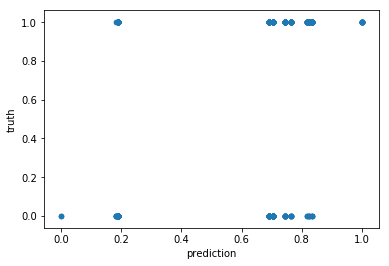

In [84]:
results.plot(kind='scatter', x='prediction', y='truth')

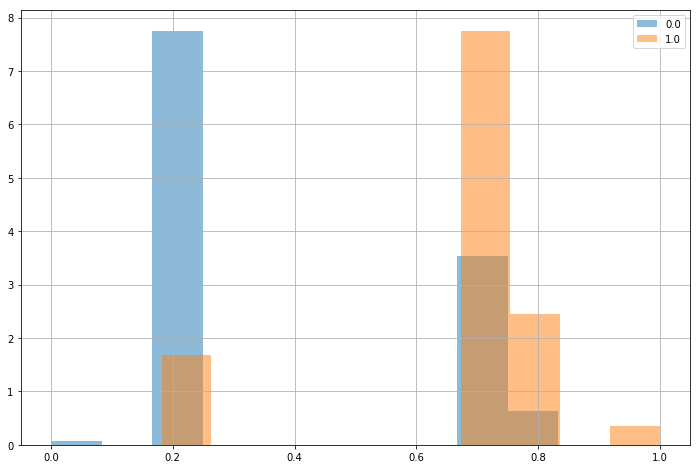

In [100]:
fig = plt.figure(figsize=(12,8))

for label, grp in tree.predict(features, leaf_map).groupby(targets):
    grp.hist(normed=True, alpha=0.5, label=str(label)) #, label=label)
plt.legend(loc='best')
None


In [ ]:
gtree.tree_logger.setLevel(logging.WARNING)

features, targets = make_hastie_sample(n_samples=50)

tree, loss, generations = gtree.evolve(features, targets, loss_fn=gtree.accuracy_loss, max_depth=3,
                                      num_generations=8, alphas_per_generation=5, betas_per_generation=5)

03:22:26 DEBUG:Growing Alpha: 1 of 5
03:22:38 DEBUG:Growing Alpha: 2 of 5
03:22:49 DEBUG:Growing Alpha: 3 of 5
03:22:58 DEBUG:Growing Alpha: 4 of 5
03:23:09 DEBUG:Growing Alpha: 5 of 5
03:23:22 DEBUG:Growing Betea: 1 of 5
03:23:42 DEBUG:Growing Betea: 2 of 5
03:24:02 DEBUG:Growing Betea: 3 of 5
03:24:22 DEBUG:Growing Betea: 4 of 5
03:24:39 DEBUG:Growing Betea: 5 of 5
03:24:54 INFO:Generation 0 Loss 3

03:24:54 DEBUG:Growing Alpha: 1 of 5
03:25:05 DEBUG:Growing Alpha: 2 of 5
03:25:17 DEBUG:Growing Alpha: 3 of 5
03:25:30 DEBUG:Growing Alpha: 4 of 5
03:25:39 DEBUG:Growing Alpha: 5 of 5
03:25:51 DEBUG:Growing Betea: 1 of 5
03:26:08 DEBUG:Growing Betea: 2 of 5
03:26:24 DEBUG:Growing Betea: 3 of 5
03:26:41 DEBUG:Growing Betea: 4 of 5
03:27:00 DEBUG:Growing Betea: 5 of 5
03:27:18 INFO:Generation 1 Loss 3

03:27:18 DEBUG:Growing Alpha: 1 of 5
03:27:29 DEBUG:Growing Alpha: 2 of 5
03:27:37 DEBUG:Growing Alpha: 3 of 5


In [136]:
loss

2